In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 11.1 MB/s 


In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
import mahotas
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew, entropy
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import skimage
from skimage import io, exposure, morphology, filters, color, segmentation, feature, measure, img_as_float, img_as_ubyte, transform
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

In [ ]:
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 8.5 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

2713
2713
2632
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
class LBP:
  def __init__(self, points, radius):
    self.points= points
    self.radius= radius
  def compute(self,image,e=1e-08):
    lbp_feature= feature.local_binary_pattern(image, self.points, self.radius, method="uniform")
    (lbp_histogram,_)= np.histogram(lbp_feature.ravel(), bins=np.arange(0, self.points + 3))

    #Normalization of the histogram
    lbp_histogram= lbp_histogram.astype("float")
    lbp_histogram /= (lbp_histogram.sum()+e)

    return lbp_histogram


In [ ]:
def LBP_feature_extractor(images_routes):
  lbp_histograms1=[]
  lbp_histograms2=[]
  lbp_histograms3=[]
  mean_histograms1=[]
  mean_histograms2=[]
  mean_histograms3=[]
  std_histograms1=[]
  std_histograms2=[]
  std_histograms3=[]
  kurtosis_histograms1=[]
  kurtosis_histograms2=[]
  kurtosis_histograms3=[]
  skew_histograms1=[]
  skew_histograms2=[]
  skew_histograms3=[]
  entropy_histograms1=[]
  entropy_histograms2=[]
  entropy_histograms3=[]
  lbp_object1= LBP(8,1)
  lbp_object2= LBP(16,2)
  lbp_object3= LBP(24,3)
  for i in images_routes:
    img= cv2.imread(i)
    img_bw= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    lbp_hist1=lbp_object1.compute(img_bw)
    lbp_hist2=lbp_object2.compute(img_bw)
    lbp_hist3=lbp_object3.compute(img_bw)
    mean_histograms1.append(np.mean(lbp_hist1))
    mean_histograms2.append(np.mean(lbp_hist2))
    mean_histograms3.append(np.mean(lbp_hist3))

    std_histograms1.append(np.std(lbp_hist1))
    std_histograms2.append(np.std(lbp_hist2))
    std_histograms3.append(np.std(lbp_hist3))

    kurtosis_histograms1.append(kurtosis(lbp_hist1))
    kurtosis_histograms2.append(kurtosis(lbp_hist2))
    kurtosis_histograms3.append(kurtosis(lbp_hist3))

    skew_histograms1.append(skew(lbp_hist1))
    skew_histograms2.append(skew(lbp_hist2))
    skew_histograms3.append(skew(lbp_hist3))

    entropy_histograms1.append(entropy(lbp_hist1))
    entropy_histograms2.append(entropy(lbp_hist2))
    entropy_histograms3.append(entropy(lbp_hist3))

    lbp_histograms1.append(lbp_hist1)
    lbp_histograms2.append(lbp_hist2)
    lbp_histograms3.append(lbp_hist3)

  LBP_features1= pd.DataFrame(data= lbp_histograms1)
  LBP_features2= pd.DataFrame(data= lbp_histograms2)
  LBP_features3= pd.DataFrame(data= lbp_histograms3)

  LBP_Statistics1= {'mean': mean_histograms1, 'std':std_histograms1, 'kurtosis': kurtosis_histograms1, 'skew': skew_histograms1, 'entropy': entropy_histograms1}
  LBP_Statistics2= {'mean': mean_histograms2, 'std':std_histograms2, 'kurtosis': kurtosis_histograms2, 'skew': skew_histograms2, 'entropy': entropy_histograms2}
  LBP_Statistics3= {'mean': mean_histograms3, 'std':std_histograms3, 'kurtosis': kurtosis_histograms3, 'skew': skew_histograms3, 'entropy': entropy_histograms3}

  LBP_statistics1_result= pd.DataFrame.from_dict(LBP_Statistics1)
  LBP_statistics2_result= pd.DataFrame.from_dict(LBP_Statistics2)
  LBP_statistics3_result= pd.DataFrame.from_dict(LBP_Statistics3)


  return LBP_features1, LBP_features2, LBP_features3, LBP_statistics1_result, LBP_statistics2_result, LBP_statistics3_result

In [ ]:
LBP_features1_train, LBP_features2_train, LBP_features3_train, LBP_statistics1_result_train, LBP_statistics2_result_train, LBP_statistics3_result_train= LBP_feature_extractor(X_train)
LBP_features1_test, LBP_features2_test, LBP_features3_test, LBP_statistics1_result_test, LBP_statistics2_result_test, LBP_statistics3_result_test= LBP_feature_extractor(X_test)

In [ ]:
# LBP_features1_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features1_train_291022.csv',index=False)
# LBP_features2_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features2_train_291022.csv',index=False)
# LBP_features3_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_LBP_features3_train_291022.csv',index=False)
# LBP_statistics1_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics1_result_train_291022.csv',index=False)
# LBP_statistics2_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics2_result_train_291022.csv',index=False)
# LBP_statistics3_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics3_result_train_291022.csv',index=False)

# LBP_features1_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features1_test_291022.csv',index=False)
# LBP_features2_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features2_test_291022.csv',index=False)
# LBP_features3_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features3_test_291022.csv',index=False)
# LBP_statistics1_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics1_result_test_291022.csv',index=False)
# LBP_statistics2_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics2_result_test_291022.csv',index=False)
# LBP_statistics3_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics3_result_test_29022.csv',index=False)

In [ ]:
LBP_features1_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features1_train_291022.csv')
LBP_features2_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features2_train_291022.csv')
LBP_features3_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_LBP_features3_train_291022.csv')
LBP_statistics1_result_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics1_result_train_291022.csv')
LBP_statistics2_result_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics2_result_train_291022.csv')
LBP_statistics3_result_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics3_result_train_291022.csv')

LBP_features1_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features1_test_291022.csv')
LBP_features2_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features2_test_291022.csv')
LBP_features3_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_features3_test_291022.csv')
LBP_statistics1_result_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics1_result_test_291022.csv')
LBP_statistics2_result_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics2_result_test_291022.csv')
LBP_statistics3_result_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/LBP_statistics3_result_test_29022.csv')

In [ ]:
LBP_histogram_features_train= pd.concat([LBP_features1_train, LBP_features2_train, LBP_features3_train], axis=1)
LBP_histogram_features_test= pd.concat([LBP_features1_test, LBP_features2_test, LBP_features3_test], axis=1)

In [ ]:
LBP_statistics_features_train= pd.concat([LBP_statistics1_result_train,LBP_statistics2_result_train, LBP_statistics3_result_train], axis=1)
LBP_statistics_features_test= pd.concat([LBP_statistics1_result_test,LBP_statistics2_result_test, LBP_statistics3_result_test], axis=1)

In [ ]:
X_train_features= LBP_histogram_features_train
X_test_features= LBP_histogram_features_test
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       678
           1       0.61      0.65      0.63       498
           2       0.03      0.01      0.02        94

    accuracy                           0.65      1270
   macro avg       0.45      0.46      0.45      1270
weighted avg       0.62      0.65      0.63      1270

0.4635986990704297
Kappa Score :
0.34121037463976944


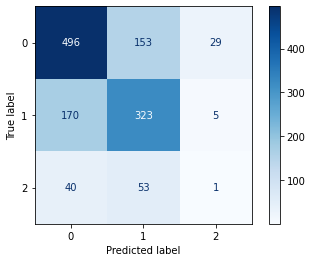

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model1, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/LBPHSVM_model.sav', 'wb'))

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       678
           1       0.58      0.69      0.63       498
           2       0.06      0.03      0.04        94

    accuracy                           0.62      1270
   macro avg       0.45      0.46      0.45      1270
weighted avg       0.61      0.62      0.61      1270

0.4565458217732538
Kappa Score :
0.3083909411679988


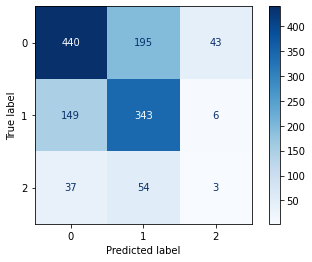

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       678
           1       0.60      0.62      0.61       498
           2       0.11      0.06      0.08        94

    accuracy                           0.63      1270
   macro avg       0.47      0.47      0.47      1270
weighted avg       0.61      0.63      0.62      1270

0.46672801795268687
Kappa Score :
0.3192942281989408


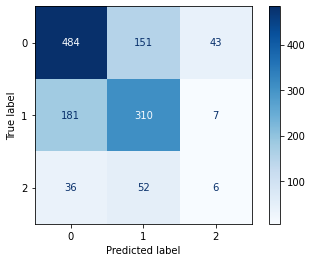

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model3, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/LBPHGBoost_model.sav', 'wb'))

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       678
           1       0.65      0.65      0.65       498
           2       0.22      0.13      0.16        94

    accuracy                           0.67      1270
   macro avg       0.53      0.51      0.52      1270
weighted avg       0.66      0.67      0.66      1270

0.5149383071733366
Kappa Score :
0.3973127501429389


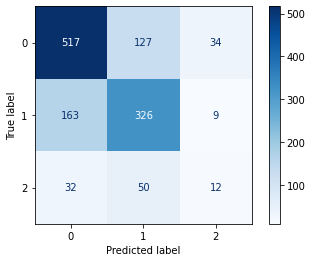

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model4, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/LBPHRF_model.sav', 'wb'))

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       678
           1       0.57      0.48      0.52       498
           2       0.03      0.03      0.03        94

    accuracy                           0.56      1270
   macro avg       0.41      0.40      0.40      1270
weighted avg       0.56      0.56      0.56      1270

0.401683303854973
Kappa Score :
0.1946642786684788


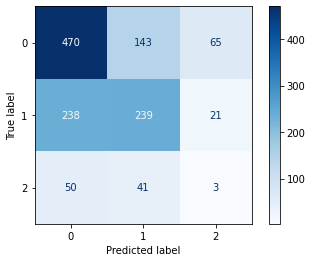

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       678
           1       0.55      0.56      0.55       498
           2       0.17      0.23      0.20        94

    accuracy                           0.57      1270
   macro avg       0.47      0.48      0.47      1270
weighted avg       0.59      0.57      0.58      1270

0.4754979246679809
Kappa Score :
0.2517217600796068


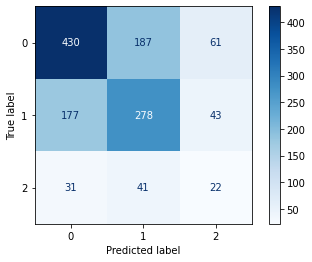

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       678
           1       0.60      0.58      0.59       498
           2       0.07      0.04      0.05        94

    accuracy                           0.61      1270
   macro avg       0.44      0.45      0.44      1270
weighted avg       0.60      0.61      0.60      1270

0.44642664047264186
Kappa Score :
0.2848608039993956


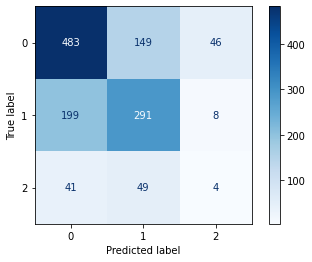

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       678
           1       0.53      0.42      0.47       498
           2       0.12      0.24      0.16        94

    accuracy                           0.50      1270
   macro avg       0.41      0.42      0.41      1270
weighted avg       0.53      0.50      0.51      1270

0.41909330663518957
Kappa Score :
0.13908583561071486


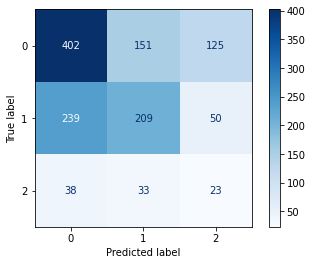

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       678
           1       0.59      0.61      0.60       498
           2       0.14      0.11      0.12        94

    accuracy                           0.62      1270
   macro avg       0.48      0.47      0.47      1270
weighted avg       0.61      0.62      0.62      1270

0.47345485626684236
Kappa Score :
0.3134003909688895


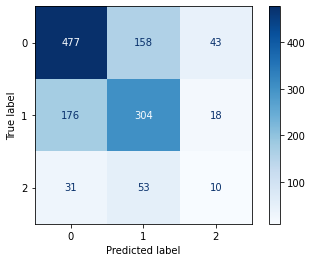

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model9, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/LBPHKNN_model.sav', 'wb'))

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       678
           1       0.65      0.65      0.65       498
           2       0.19      0.11      0.14        94

    accuracy                           0.67      1270
   macro avg       0.52      0.51      0.51      1270
weighted avg       0.66      0.67      0.66      1270

0.5098126769300261
Kappa Score :
0.3990132317690789


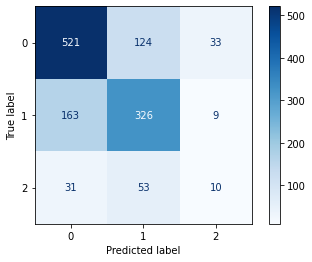

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       678
           1       0.65      0.67      0.66       498
           2       0.28      0.12      0.17        94

    accuracy                           0.69      1270
   macro avg       0.56      0.52      0.53      1270
weighted avg       0.67      0.69      0.67      1270

0.522018784987436
Kappa Score :
0.4173344891503823


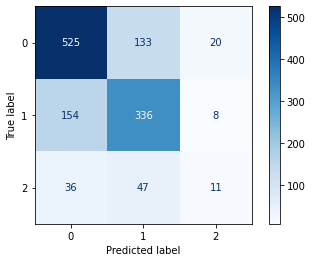

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
X_train_features= LBP_statistics_features_train
X_test_features= LBP_statistics_features_test
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       678
           1       0.56      0.52      0.54       498
           2       0.06      0.06      0.06        94

    accuracy                           0.55      1270
   macro avg       0.41      0.41      0.41      1270
weighted avg       0.56      0.55      0.55      1270

0.4088564135409396
Kappa Score :
0.19510860863532042


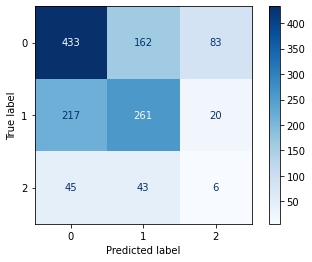

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.61      0.59       678
           1       0.52      0.46      0.49       498
           2       0.04      0.04      0.04        94

    accuracy                           0.51      1270
   macro avg       0.38      0.37      0.37      1270
weighted avg       0.51      0.51      0.51      1270

0.3721649921092769
Kappa Score :
0.11784247402754289


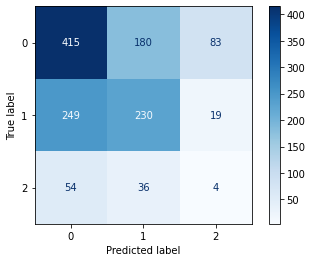

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62       678
           1       0.54      0.57      0.55       498
           2       0.04      0.04      0.04        94

    accuracy                           0.55      1270
   macro avg       0.41      0.41      0.41      1270
weighted avg       0.55      0.55      0.55      1270

0.4083095704225299
Kappa Score :
0.19924159864777713


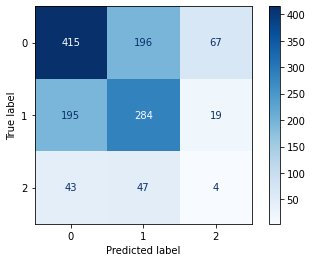

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       678
           1       0.57      0.57      0.57       498
           2       0.12      0.11      0.11        94

    accuracy                           0.59      1270
   macro avg       0.45      0.45      0.45      1270
weighted avg       0.59      0.59      0.59      1270

0.4505905376353843
Kappa Score :
0.26186274026724476


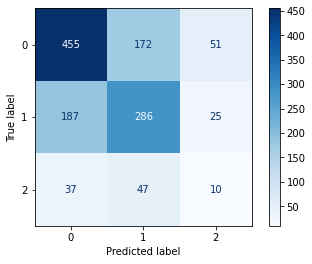

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       678
           1       0.50      0.57      0.53       498
           2       0.07      0.09      0.08        94

    accuracy                           0.52      1270
   macro avg       0.40      0.40      0.40      1270
weighted avg       0.53      0.52      0.53      1270

0.4005477757386162
Kappa Score :
0.15771836971555986


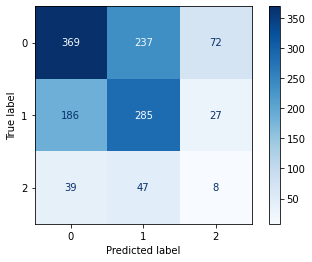

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       678
           1       0.50      0.52      0.51       498
           2       0.13      0.22      0.17        94

    accuracy                           0.52      1270
   macro avg       0.42      0.43      0.42      1270
weighted avg       0.54      0.52      0.53      1270

0.43304101991345784
Kappa Score :
0.16945722563053844


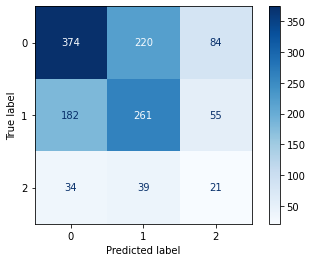

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       678
           1       0.55      0.58      0.56       498
           2       0.07      0.04      0.05        94

    accuracy                           0.59      1270
   macro avg       0.43      0.43      0.43      1270
weighted avg       0.57      0.59      0.58      1270

0.43132197401921757
Kappa Score :
0.24661114798214434


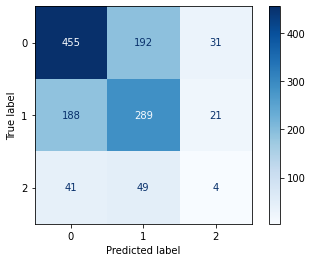

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.55      0.76      0.63       678
           1       0.49      0.19      0.27       498
           2       0.05      0.07      0.06        94

    accuracy                           0.48      1270
   macro avg       0.36      0.34      0.32      1270
weighted avg       0.49      0.48      0.45      1270

0.3401311264010413
Kappa Score :
0.03966654832328953


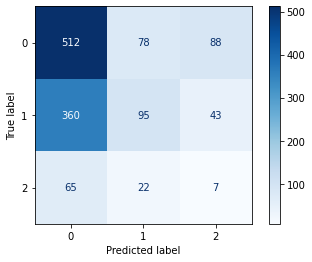

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       678
           1       0.55      0.54      0.55       498
           2       0.10      0.10      0.10        94

    accuracy                           0.57      1270
   macro avg       0.43      0.43      0.43      1270
weighted avg       0.57      0.57      0.57      1270

0.43061293060272215
Kappa Score :
0.22264815211952238


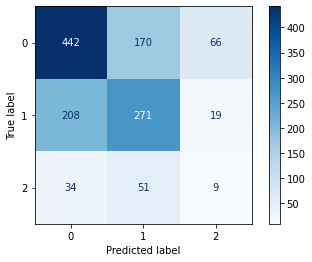

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       678
           1       0.57      0.58      0.58       498
           2       0.09      0.07      0.08        94

    accuracy                           0.59      1270
   macro avg       0.44      0.44      0.44      1270
weighted avg       0.58      0.59      0.59      1270

0.44079928576415744
Kappa Score :
0.25628650172420775


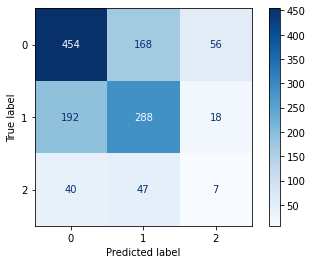

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       678
           1       0.57      0.60      0.59       498
           2       0.13      0.11      0.12        94

    accuracy                           0.61      1270
   macro avg       0.46      0.46      0.46      1270
weighted avg       0.60      0.61      0.60      1270

0.46210562453164195
Kappa Score :
0.2855265994717836


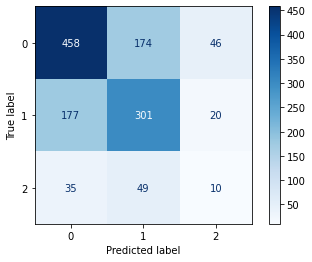

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()